In [14]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "1"

import pandas as pd
import numpy as np
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
BASE_DIR = Path(".").resolve()
DATA_DIR = BASE_DIR / "Dataset"
TRAIN_PATH = DATA_DIR / "train.csv"
TEST_PATH = DATA_DIR / "test.csv"

# Dataset import (CSV)
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

# Shape, columns, data types check
print("=== SHAPE ===")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print("\n=== COLUMNS ===")
print(f"Train columns: {list(train_df.columns)}")
print("\n=== DATA TYPES ===")
print(train_df.dtypes)
train_df.head()

=== SHAPE ===
Train shape: (15000, 14)
Test shape: (10000, 13)

=== COLUMNS ===
Train columns: ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

=== DATA TYPES ===
id                   int64
CustomerId         float64
Surname                str
CreditScore        float64
Geography              str
Gender                 str
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited             float64
dtype: object


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15634591.0,Pagnotto,775.0,France,Male,29.0,4.0,0.00,2.0,1.0,0.0,61315.37,0.0
1,1,15584364.0,Aksenov,599.0,Spain,Female,38.0,7.0,0.00,2.0,1.0,0.0,180622.01,0.0
2,2,15662854.0,Y?an,602.0,France,Male,45.0,5.0,0.00,2.0,1.0,0.0,173989.66,0.0
3,3,15726153.0,Lai,775.0,France,Male,42.0,7.0,89158.84,1.0,1.0,1.0,180698.32,0.0
4,4,15743193.0,Chukwuebuka,663.0,Germany,Male,39.0,2.0,129663.49,1.0,0.0,1.0,172363.41,0.0


In [ ]:
# Missing values
print("Missing values (train):")
print(train_df.isnull().sum())
print("\nMissing values (test):")
print(test_df.isnull().sum())

Missing values (train):
id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Missing values (test):
id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64


In [16]:
# Handle missing: drop ID-like cols, fill numeric with median, categorical with mode
drop_cols = [c for c in ["id", "CustomerId", "Surname", "RowNumber"] if c in train_df.columns]
train_clean = train_df.drop(columns=drop_cols, errors="ignore")
test_clean = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns], errors="ignore")

numeric_cols = train_clean.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    if col != "Exited" and col in train_clean.columns:
        med = train_clean[col].median()
        train_clean[col] = train_clean[col].fillna(med)
    if col in test_clean.columns:
        med = train_clean[col].median()
        test_clean[col] = test_clean[col].fillna(med)

cat_cols_clean = [c for c in train_clean.select_dtypes(include=["object"]).columns if c != "Exited"]
for col in cat_cols_clean:
    if col in train_clean.columns:
        mode_val = train_clean[col].mode()[0] if len(train_clean[col].mode()) > 0 else "Unknown"
        train_clean[col] = train_clean[col].fillna(mode_val)
    if col in test_clean.columns:
        mode_val = train_clean[col].mode()[0] if len(train_clean[col].mode()) > 0 else "Unknown"
        test_clean[col] = test_clean[col].fillna(mode_val)
print("Missing values after handling:", train_clean.isnull().sum().sum(), "(train)", test_clean.isnull().sum().sum(), "(test)")

Missing values after handling: 0 (train) 0 (test)


C:\Users\DELL\AppData\Local\Temp\ipykernel_15768\2636882342.py:15: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols_clean = [c for c in train_clean.select_dtypes(include=["object"]).columns if c != "Exited"]


In [17]:
# Outliers treatment (IQR cap for numeric columns)
from sklearn.preprocessing import LabelEncoder

def cap_outliers_iqr(df, cols, factor=1.5):
    out = df.copy()
    for col in cols:
        if col not in out.columns or col == "Exited": continue
        Q1, Q3 = out[col].quantile(0.25), out[col].quantile(0.75)
        IQR = Q3 - Q1
        low, high = Q1 - factor * IQR, Q3 + factor * IQR
        out[col] = out[col].clip(low, high)
    return out

num_for_outlier = [c for c in numeric_cols if c != "Exited" and c in train_clean.columns]
train_clean = cap_outliers_iqr(train_clean, num_for_outlier)
test_clean = cap_outliers_iqr(test_clean, num_for_outlier)
print("Outliers capped using IQR (factor=1.5) for columns:", num_for_outlier[:5], "...")

Outliers capped using IQR (factor=1.5) for columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts'] ...


In [18]:
# Encoding (Label Encoding for categorical)
label_encoders = {}
for col in cat_cols_clean:
    le = LabelEncoder()
    all_vals = pd.concat([train_clean[col].astype(str), test_clean[col].astype(str)], ignore_index=True)
    le.fit(all_vals.unique())
    train_clean[col] = le.transform(train_clean[col].astype(str))
    test_clean[col] = le.transform(test_clean[col].astype(str))
    label_encoders[col] = le
print("Label encoding applied to:", cat_cols_clean)

Label encoding applied to: ['Geography', 'Gender']


In [19]:
# Qualitative: non-numerical (on raw train_df)
print("=== QUALITATIVE (Non-numerical) ===\nGeography:")
print(train_df["Geography"].value_counts())
print("\nGender:")
print(train_df["Gender"].value_counts())
print("\n=== QUANTITATIVE (Numerical) ===\nDescriptive stats:")
print(train_df.describe())
print("\nVariance (key numeric):")
print(train_df[["CreditScore", "Age", "Balance", "EstimatedSalary"]].var())

=== QUALITATIVE (Non-numerical) ===
Geography:
Geography
France     8847
Spain      3319
Germany    2834
Name: count, dtype: int64

Gender:
Gender
Male      8426
Female    6574
Name: count, dtype: int64

=== QUANTITATIVE (Numerical) ===
Descriptive stats:
                 id    CustomerId   CreditScore           Age        Tenure  \
count  15000.000000  1.500000e+04  15000.000000  15000.000000  15000.000000   
mean    7499.500000  1.570151e+07    658.204800     37.823933      5.058400   
std     4330.271354  1.163458e+06     73.120097      8.197387      2.793524   
min        0.000000  1.556580e+07    431.000000     18.000000      0.000000   
25%     3749.750000  1.563258e+07    603.000000     32.000000      3.000000   
50%     7499.500000  1.568995e+07    659.000000     37.000000      5.000000   
75%    11249.250000  1.575784e+07    709.000000     42.000000      7.000000   
max    14999.000000  1.579150e+08    850.000000     74.000000     10.000000   

             Balance  NumOfProdu

In [20]:
# Categorical / Class distribution & imbalance
print("=== TARGET (Exited) DISTRIBUTION ===\nCounts:")
print(train_df["Exited"].value_counts())
print("\nProportions:")
print(train_df["Exited"].value_counts(normalize=True))
imbalance_ratio = (train_df["Exited"] == 0).sum() / max((train_df["Exited"] == 1).sum(), 1)
print(f"\nClass imbalance ratio (Stayed:Churned) ≈ {imbalance_ratio:.2f}:1 — consider class_weight/scale_pos_weight in models.")

=== TARGET (Exited) DISTRIBUTION ===
Counts:
Exited
0.0    11927
1.0     3073
Name: count, dtype: int64

Proportions:
Exited
0.0    0.795133
1.0    0.204867
Name: proportion, dtype: float64

Class imbalance ratio (Stayed:Churned) ≈ 3.88:1 — consider class_weight/scale_pos_weight in models.


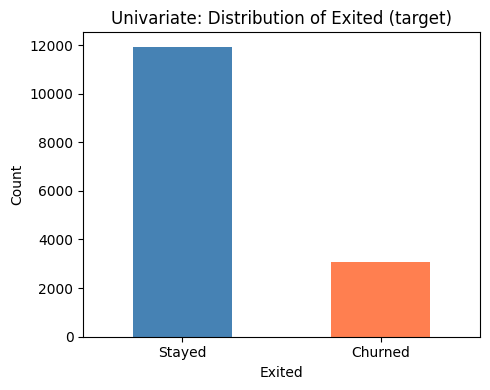

In [21]:
# EDA: Univariate — Target (Exited)
fig, ax = plt.subplots(figsize=(5, 4))
train_df["Exited"].value_counts().sort_index().plot(kind="bar", ax=ax, color=["steelblue", "coral"])
ax.set_xticklabels(["Stayed", "Churned"], rotation=0)
ax.set_ylabel("Count")
ax.set_title("Univariate: Distribution of Exited (target)")
plt.tight_layout()
plt.show()
# INTERPRETATION: Bar chart shows class imbalance; more customers stayed (0) than churned (1). Model should account for this (e.g. class weights).

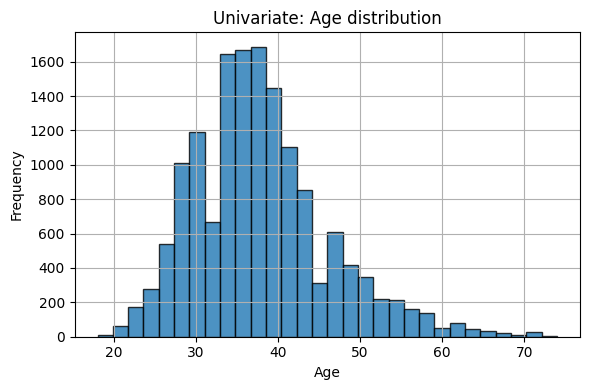

In [22]:
# Univariate: Age histogram
fig, ax = plt.subplots(figsize=(6, 4))
train_df["Age"].hist(ax=ax, bins=30, edgecolor="black", alpha=0.8)
ax.set_xlabel("Age")
ax.set_ylabel("Frequency")
ax.set_title("Univariate: Age distribution")
plt.tight_layout()
plt.show()
# INTERPRETATION: Age is roughly right-skewed; most customers are in mid-age range. Useful for segmentation.

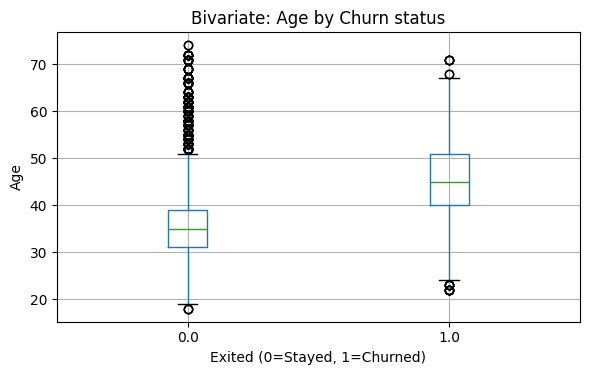

In [23]:
# Bivariate: Age by Exited (boxplot)
fig, ax = plt.subplots(figsize=(6, 4))
train_df.boxplot(column="Age", by="Exited", ax=ax)
ax.set_xlabel("Exited (0=Stayed, 1=Churned)")
ax.set_ylabel("Age")
ax.set_title("Bivariate: Age by Churn status")
plt.suptitle("")
plt.tight_layout()
plt.show()
# INTERPRETATION: Churned customers tend to have higher median Age; Age is a useful predictor for churn.

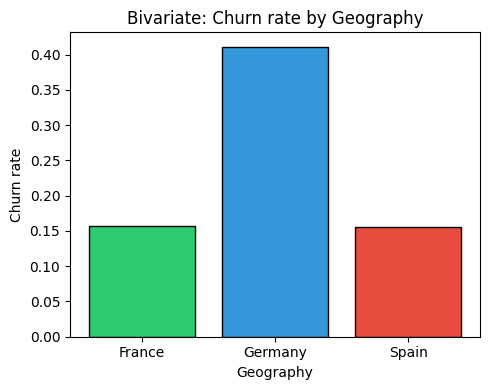

In [24]:
# Bivariate: Churn rate by Geography
churn_by_geo = train_df.groupby("Geography")["Exited"].agg(["mean", "count"]).reset_index()
fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(churn_by_geo["Geography"], churn_by_geo["mean"], color=["#2ecc71", "#3498db", "#e74c3c"], edgecolor="black")
ax.set_xlabel("Geography")
ax.set_ylabel("Churn rate")
ax.set_title("Bivariate: Churn rate by Geography")
plt.tight_layout()
plt.show()
# INTERPRETATION: Geography shows different churn rates; Germany has higher churn in this sample — useful for targeting retention by region.

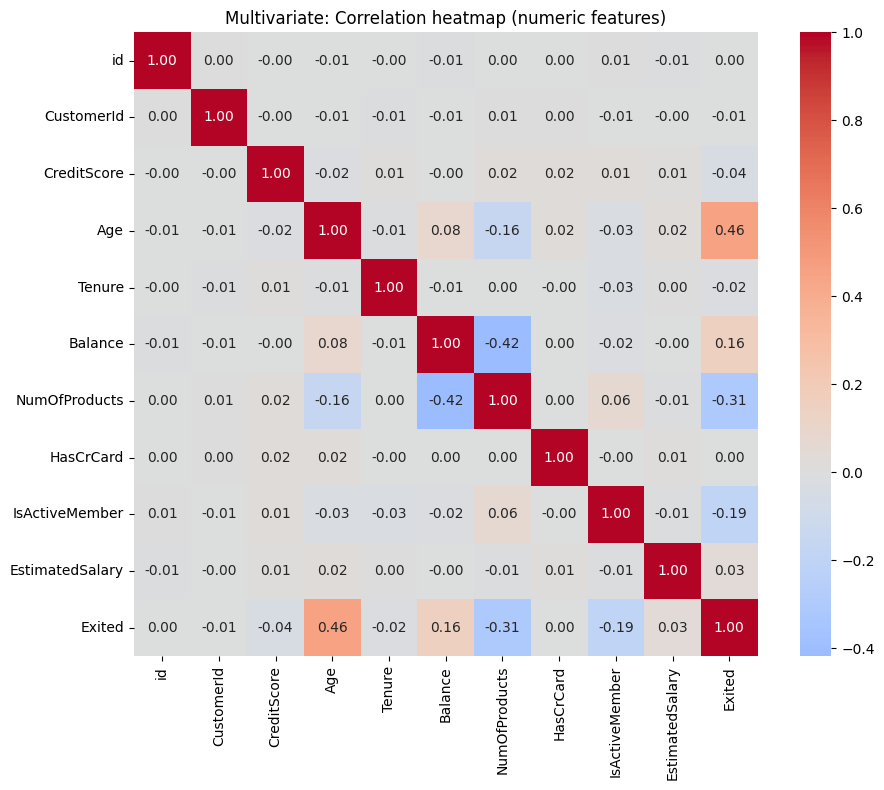

In [25]:
# Multivariate: Correlation heatmap (numeric only)
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
corr = train_df[num_cols].corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=ax, square=True)
ax.set_title("Multivariate: Correlation heatmap (numeric features)")
plt.tight_layout()
plt.show()
# INTERPRETATION: Heatmap shows strength and direction of linear relationships. High correlation with Exited or between predictors guides feature selection and multicollinearity check.

In [26]:
# Feature engineering: KMeans cluster + derived features
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

cluster_features = [c for c in numeric_cols if c != "Exited" and c in train_clean.columns]
if not cluster_features:
    cluster_features = [c for c in train_clean.columns if c != "Exited" and train_clean[c].dtype in [np.float64, np.int64]]
X_cluster_train = train_clean[cluster_features].copy()
X_cluster_test = test_clean[cluster_features].copy()
scaler_cluster = StandardScaler()
X_cluster_train_scaled = scaler_cluster.fit_transform(X_cluster_train)
X_cluster_test_scaled = scaler_cluster.transform(X_cluster_test)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
train_clean["Cluster"] = kmeans.fit_predict(X_cluster_train_scaled)
test_clean["Cluster"] = kmeans.predict(X_cluster_test_scaled)

def add_engineered_features(df):
    out = df.copy()
    if "Balance" in out.columns and "EstimatedSalary" in out.columns:
        out["BalanceToSalary"] = out["Balance"] / (out["EstimatedSalary"] + 1)
    if "Age" in out.columns and "Tenure" in out.columns:
        out["AgeTenure"] = out["Age"] * (out["Tenure"] + 1)
    if "CreditScore" in out.columns:
        out["CreditScoreNorm"] = (out["CreditScore"] - 350) / 500
    if "Age" in out.columns and "NumOfProducts" in out.columns:
        out["AgeNumProducts"] = out["Age"] * out["NumOfProducts"]
    if "Balance" in out.columns and "NumOfProducts" in out.columns:
        out["BalanceNumProducts"] = out["Balance"] * (out["NumOfProducts"] + 1)
    if "IsActiveMember" in out.columns and "HasCrCard" in out.columns:
        out["ActiveWithCard"] = out["IsActiveMember"] * out["HasCrCard"]
    return out
train_clean = add_engineered_features(train_clean)
test_clean = add_engineered_features(test_clean)
feature_cols = [c for c in train_clean.columns if c != "Exited"]
X = train_clean[feature_cols]
y = train_clean["Exited"].astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_full_scaled = scaler.fit_transform(X)
X_test = test_clean[feature_cols]
X_test_scaled = scaler.transform(X_test)
print("Feature count:", len(feature_cols), "| Train size:", X_train.shape[0], "| Val size:", X_val.shape[0])

Feature count: 17 | Train size: 12000 | Val size: 3000


In [27]:
# Imports for models and evaluation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score, learning_curve
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
try:
    plt.style.use("seaborn-v0_8-whitegrid")
except Exception:
    plt.style.use("ggplot")

In [28]:
# Hyperparameter tuning (GridSearchCV for one model as example; others use tuned defaults)
from sklearn.model_selection import GridSearchCV
scale_pos_weight = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
param_grid_dt = {"max_depth": [8, 10, 12], "min_samples_leaf": [5, 10, 20]}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), param_grid_dt, cv=3, scoring="roc_auc", n_jobs=1)
grid_dt.fit(X_train_scaled, y_train)
print("Decision Tree best params:", grid_dt.best_params_, "| Best CV ROC-AUC:", grid_dt.best_score_.round(4))

Decision Tree best params: {'max_depth': 8, 'min_samples_leaf': 20} | Best CV ROC-AUC: 0.904


In [ ]:
# Train 3 models (XGBoost, Gradient Boosting, Decision Tree)
model_xgb = xgb.XGBClassifier(n_estimators=400, max_depth=6, learning_rate=0.03, 
subsample=0.8, colsample_bytree=0.8,reg_alpha=0.1, reg_lambda=1.0, min_child_weight=3,
scale_pos_weight=scale_pos_weight,
random_state=RANDOM_STATE, use_label_encoder=False, eval_metric="logloss")
model_xgb.fit(X_train_scaled, y_train)

model_gbm = GradientBoostingClassifier(n_estimators=400, max_depth=6, learning_rate=0.03, subsample=0.8, min_samples_leaf=20, random_state=RANDOM_STATE)
model_gbm.fit(X_train_scaled, y_train)

model_dt = DecisionTreeClassifier(max_depth=grid_dt.best_params_["max_depth"], min_samples_leaf=grid_dt.best_params_["min_samples_leaf"], random_state=RANDOM_STATE)
model_dt.fit(X_train_scaled, y_train)
print("All 3 models trained.")

All 3 models trained.


In [30]:
# Cross-validation (5-fold ROC-AUC)
cv_xgb = cross_val_score(model_xgb, X_full_scaled, y, cv=5, scoring="roc_auc", n_jobs=1)
cv_gbm = cross_val_score(model_gbm, X_full_scaled, y, cv=5, scoring="roc_auc", n_jobs=1)
cv_dt = cross_val_score(model_dt, X_full_scaled, y, cv=5, scoring="roc_auc", n_jobs=1)
print("5-Fold CV ROC-AUC — XGBoost: mean =", cv_xgb.mean().round(4), "std =", cv_xgb.std().round(4))
print("5-Fold CV ROC-AUC — Gradient Boosting: mean =", cv_gbm.mean().round(4), "std =", cv_gbm.std().round(4))
print("5-Fold CV ROC-AUC — Decision Tree: mean =", cv_dt.mean().round(4), "std =", cv_dt.std().round(4))
comparison_cv = pd.DataFrame({"XGBoost": [cv_xgb.mean(), cv_xgb.std()], "Gradient Boosting": [cv_gbm.mean(), cv_gbm.std()], "Decision Tree": [cv_dt.mean(), cv_dt.std()]}, index=["mean", "std"])
print(comparison_cv)

5-Fold CV ROC-AUC — XGBoost: mean = 0.923 std = 0.0057
5-Fold CV ROC-AUC — Gradient Boosting: mean = 0.9246 std = 0.0052
5-Fold CV ROC-AUC — Decision Tree: mean = 0.9088 std = 0.0097
       XGBoost  Gradient Boosting  Decision Tree
mean  0.922961           0.924556       0.908812
std   0.005701           0.005207       0.009750


In [31]:
# Evaluation helper
def evaluate_model(name, y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba[:, 1]) if y_proba is not None else 0.0
    print(f"{name}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, ROC-AUC={auc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

y_pred_xgb = model_xgb.predict(X_val_scaled)
y_proba_xgb = model_xgb.predict_proba(X_val_scaled)
y_pred_gbm = model_gbm.predict(X_val_scaled)
y_proba_gbm = model_gbm.predict_proba(X_val_scaled)
y_pred_dt = model_dt.predict(X_val_scaled)
y_proba_dt = model_dt.predict_proba(X_val_scaled)
metrics_xgb = evaluate_model("XGBoost", y_val, y_pred_xgb, y_proba_xgb)
metrics_gbm = evaluate_model("Gradient Boosting", y_val, y_pred_gbm, y_proba_gbm)
metrics_dt = evaluate_model("Decision Tree", y_val, y_pred_dt, y_proba_dt)

XGBoost: Accuracy=0.8680, Precision=0.6458, Recall=0.7886, F1=0.7101, ROC-AUC=0.9197
Confusion Matrix:
 [[2119  266]
 [ 130  485]]
Gradient Boosting: Accuracy=0.8943, Precision=0.7865, Recall=0.6650, F1=0.7207, ROC-AUC=0.9229
Confusion Matrix:
 [[2274  111]
 [ 206  409]]
Decision Tree: Accuracy=0.8837, Precision=0.7628, Recall=0.6276, F1=0.6887, ROC-AUC=0.9112
Confusion Matrix:
 [[2265  120]
 [ 229  386]]


                   accuracy  precision    recall        f1   roc_auc
XGBoost            0.868000   0.645806  0.788618  0.710102  0.919678
Gradient Boosting  0.894333   0.786538  0.665041  0.720705  0.922944
Decision Tree      0.883667   0.762846  0.627642  0.688671  0.911195


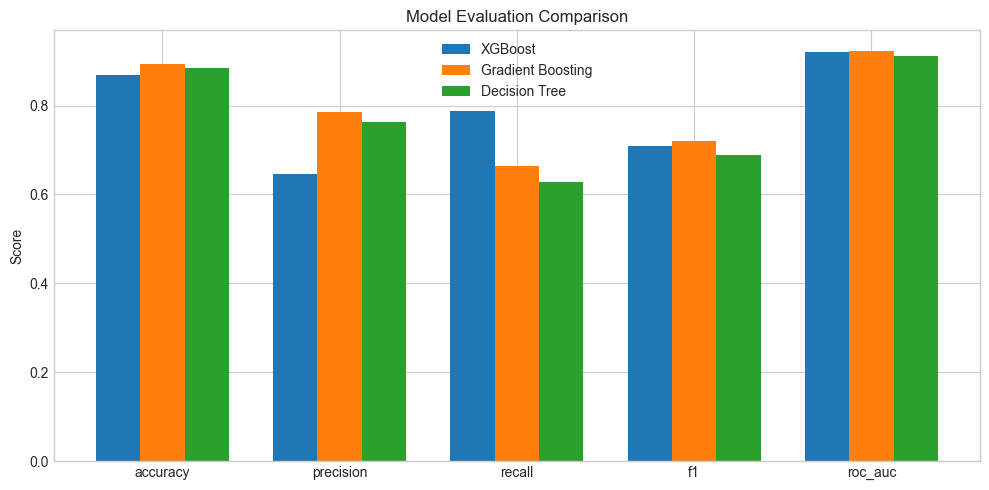

In [32]:
# Performance comparison table
comparison = pd.DataFrame({"XGBoost": metrics_xgb, "Gradient Boosting": metrics_gbm, "Decision Tree": metrics_dt}).T
print(comparison)
# Bar chart: model comparison
fig, ax = plt.subplots(figsize=(10, 5))
metrics_list = ["accuracy", "precision", "recall", "f1", "roc_auc"]
x = np.arange(len(metrics_list))
width = 0.25
ax.bar(x - width, [metrics_xgb[m] for m in metrics_list], width, label="XGBoost")
ax.bar(x, [metrics_gbm[m] for m in metrics_list], width, label="Gradient Boosting")
ax.bar(x + width, [metrics_dt[m] for m in metrics_list], width, label="Decision Tree")
ax.set_xticks(x)
ax.set_xticklabels(metrics_list)
ax.set_ylabel("Score")
ax.set_title("Model Evaluation Comparison")
ax.legend()
plt.tight_layout()
plt.show()

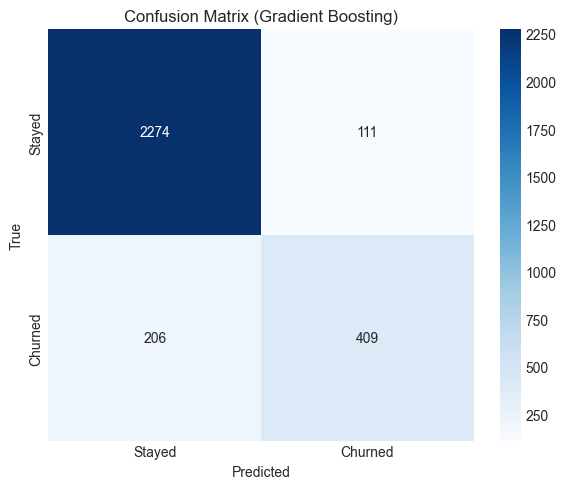

Interpretation: Rows = True class, Columns = Predicted; diagonal = correct predictions.


In [33]:
# Confusion Matrix (best model by ROC-AUC)
scores = {"XGBoost": metrics_xgb["roc_auc"], "Gradient Boosting": metrics_gbm["roc_auc"], "Decision Tree": metrics_dt["roc_auc"]}
best_name = max(scores, key=scores.get)
best_model = model_xgb if best_name == "XGBoost" else (model_gbm if best_name == "Gradient Boosting" else model_dt)
y_val_best = best_model.predict(X_val_scaled)
cm = confusion_matrix(y_val, y_val_best)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=["Stayed", "Churned"], yticklabels=["Stayed", "Churned"])
ax.set_title(f"Confusion Matrix ({best_name})")
ax.set_ylabel("True")
ax.set_xlabel("Predicted")
plt.tight_layout()
plt.show()
print("Interpretation: Rows = True class, Columns = Predicted; diagonal = correct predictions.")

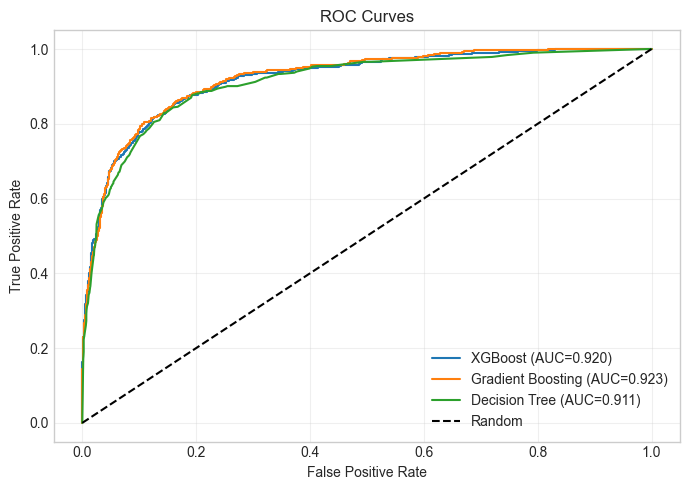

In [34]:
# ROC curves (all 3 models)
from sklearn.metrics import roc_curve
fig, ax = plt.subplots(figsize=(7, 5))
for name, y_p in [("XGBoost", y_proba_xgb[:, 1]), ("Gradient Boosting", y_proba_gbm[:, 1]), ("Decision Tree", y_proba_dt[:, 1])]:
    fpr, tpr, _ = roc_curve(y_val, y_p)
    auc_val = roc_auc_score(y_val, y_p)
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Random")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# INTERPRETATION: Curves above diagonal indicate better than random; higher AUC = better discrimination between Stayed and Churned.

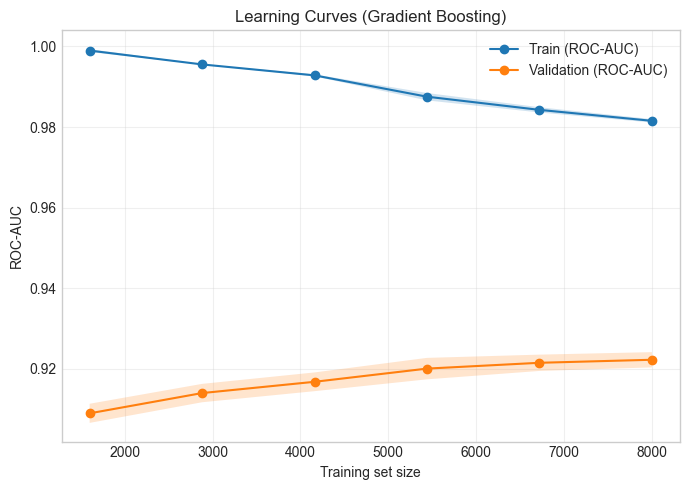

In [35]:
# Learning curves (best model)
train_sizes, train_scores, val_scores = learning_curve(best_model, X_train_scaled, y_train, cv=3, n_jobs=1,
    train_sizes=np.linspace(0.2, 1.0, 6), scoring="roc_auc")
train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
val_mean, val_std = val_scores.mean(axis=1), val_scores.std(axis=1)
fig, ax = plt.subplots(figsize=(7, 5))
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
ax.plot(train_sizes, train_mean, "o-", label="Train (ROC-AUC)")
ax.plot(train_sizes, val_mean, "o-", label="Validation (ROC-AUC)")
ax.set_xlabel("Training set size")
ax.set_ylabel("ROC-AUC")
ax.set_title(f"Learning Curves ({best_name})")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# INTERPRETATION: If validation curve plateaus below train, model may benefit from more data or regularization; if both high, model fits well.

In [36]:
# Retrain best model on full data and save (joblib)
import joblib
model_xgb_full = xgb.XGBClassifier(n_estimators=400, max_depth=6, learning_rate=0.03, subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.1, reg_lambda=1.0, min_child_weight=3, scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE, use_label_encoder=False, eval_metric="logloss")
model_gbm_full = GradientBoostingClassifier(n_estimators=400, max_depth=6, learning_rate=0.03, subsample=0.8, min_samples_leaf=20, random_state=RANDOM_STATE)
model_dt_full = DecisionTreeClassifier(max_depth=grid_dt.best_params_["max_depth"], min_samples_leaf=grid_dt.best_params_["min_samples_leaf"], random_state=RANDOM_STATE)
model_xgb_full.fit(X_full_scaled, y)
model_gbm_full.fit(X_full_scaled, y)
model_dt_full.fit(X_full_scaled, y)
preprocessing = {"scaler": scaler, "scaler_cluster": scaler_cluster, "kmeans": kmeans, "cluster_features": cluster_features, "feature_cols": feature_cols, "label_encoders": label_encoders}
joblib.dump(preprocessing, BASE_DIR / "preprocessing.pkl")
joblib.dump(model_xgb_full, BASE_DIR / "model_xgb.pkl")
joblib.dump(model_gbm_full, BASE_DIR / "model_gbm.pkl")
joblib.dump(model_dt_full, BASE_DIR / "model_dt.pkl")
print("Best model (by ROC-AUC):", best_name)
print("Saved: preprocessing.pkl, model_xgb.pkl, model_gbm.pkl, model_dt.pkl")

Best model (by ROC-AUC): Gradient Boosting
Saved: preprocessing.pkl, model_xgb.pkl, model_gbm.pkl, model_dt.pkl


In [37]:
# Feature scaling & train-test split (done after feature engineering in later cells; placeholder here)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 42
print("Train-test split and StandardScaler will be applied after feature engineering (Section 5).")
print("Preprocessing so far: missing values filled, outliers capped, Label Encoding done.")

Train-test split and StandardScaler will be applied after feature engineering (Section 5).
Preprocessing so far: missing values filled, outliers capped, Label Encoding done.


In [ ]:
# Confusion Matrix (best model by ROC-AUC)
scores = {"XGBoost": metrics_xgb["roc_auc"], "Gradient Boosting": metrics_gbm["roc_auc"], "Decision Tree": metrics_dt["roc_auc"]}
best_name = max(scores, key=scores.get)
best_model = model_xgb if best_name == "XGBoost" else (model_gbm if best_name == "Gradient Boosting" else model_dt)
y_val_best = best_model.predict(X_val_scaled)
cm = confusion_matrix(y_val, y_val_best)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=["Stayed", "Churned"], yticklabels=["Stayed", "Churned"])
ax.set_title(f"Confusion Matrix ({best_name})")
ax.set_ylabel("True")
ax.set_xlabel("Predicted")
plt.tight_layout()
plt.show()
print("Interpretation: Rows = True class, Columns = Predicted; diagonal = correct predictions.")


In [ ]:
# ROC curves (all 3 models)
from sklearn.metrics import roc_curve
fig, ax = plt.subplots(figsize=(7, 5))
for name, y_p in [("XGBoost", y_proba_xgb[:, 1]), ("Gradient Boosting", y_proba_gbm[:, 1]), ("Decision Tree", y_proba_dt[:, 1])]:
    fpr, tpr, _ = roc_curve(y_val, y_p)
    auc_val = roc_auc_score(y_val, y_p)
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")
ax.plot([0, 1], [0, 1], "k--", label="Random")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# INTERPRETATION: Curves above diagonal indicate better than random; higher AUC = better discrimination between Stayed and Churned.


In [ ]:
# Learning curves (best model)
train_sizes, train_scores, val_scores = learning_curve(best_model, X_train_scaled, y_train, cv=3, n_jobs=1,
    train_sizes=np.linspace(0.2, 1.0, 6), scoring="roc_auc")
train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
val_mean, val_std = val_scores.mean(axis=1), val_scores.std(axis=1)
fig, ax = plt.subplots(figsize=(7, 5))
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
ax.plot(train_sizes, train_mean, "o-", label="Train (ROC-AUC)")
ax.plot(train_sizes, val_mean, "o-", label="Validation (ROC-AUC)")
ax.set_xlabel("Training set size")
ax.set_ylabel("ROC-AUC")
ax.set_title(f"Learning Curves ({best_name})")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# INTERPRETATION: If validation curve plateaus below train, model may benefit from more data or regularization; if both high, model fits well.


In [ ]:
# Retrain best model on full data and save (joblib)
import joblib
model_xgb_full = xgb.XGBClassifier(n_estimators=400, max_depth=6, learning_rate=0.03, subsample=0.8, colsample_bytree=0.8,
    reg_alpha=0.1, reg_lambda=1.0, min_child_weight=3, scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE, use_label_encoder=False, eval_metric="logloss")
model_gbm_full = GradientBoostingClassifier(n_estimators=400, max_depth=6, learning_rate=0.03, subsample=0.8, min_samples_leaf=20, random_state=RANDOM_STATE)
model_dt_full = DecisionTreeClassifier(max_depth=grid_dt.best_params_["max_depth"], min_samples_leaf=grid_dt.best_params_["min_samples_leaf"], random_state=RANDOM_STATE)
model_xgb_full.fit(X_full_scaled, y)
model_gbm_full.fit(X_full_scaled, y)
model_dt_full.fit(X_full_scaled, y)
preprocessing = {"scaler": scaler, "scaler_cluster": scaler_cluster, "kmeans": kmeans, "cluster_features": cluster_features, "feature_cols": feature_cols, "label_encoders": label_encoders}
joblib.dump(preprocessing, BASE_DIR / "preprocessing.pkl")
joblib.dump(model_xgb_full, BASE_DIR / "model_xgb.pkl")
joblib.dump(model_gbm_full, BASE_DIR / "model_gbm.pkl")
joblib.dump(model_dt_full, BASE_DIR / "model_dt.pkl")
# Save metrics for frontend (accuracy %, ROC-AUC per model)
import json
metrics_for_api = {
    "XGBoost": {"accuracy": metrics_xgb["accuracy"], "roc_auc": metrics_xgb["roc_auc"]},
    "Gradient Boosting": {"accuracy": metrics_gbm["accuracy"], "roc_auc": metrics_gbm["roc_auc"]},
    "Decision Tree": {"accuracy": metrics_dt["accuracy"], "roc_auc": metrics_dt["roc_auc"]},
}
with open(BASE_DIR / "metrics.json", "w") as f:
    json.dump(metrics_for_api, f, indent=2)
print("Best model (by ROC-AUC):", best_name)
print("Saved: preprocessing.pkl, model_xgb.pkl, model_gbm.pkl, model_dt.pkl, metrics.json")
